# Competition forecast

How much do Newcastle need to improve in January?

To investigate this, we will:

* Estimate the current team strength as it stands today (31st December 2021)
* Simulate the rest of the season, while varying Newcastle's team strength
* Evaluate the approximate relegation chance at each team strength

In [ ]:
import collections
import dataclasses
import typing
import functools
import operator
import datetime as dt
import itertools
import os

import pandas as pd
import dotenv
import mezzala
import numpy as np
import matplotlib.pyplot as plt
import tqdm

import wingback.db
import wingback.team_strength

In [ ]:
%matplotlib inline

## Fetch data

In [ ]:
# Current team strength

dotenv.load_dotenv()

wingback.db.queries.connect('postgresql://{user}:{password}@{host}:{port}/{database}'.format(
    host=os.environ['DB_HOST'],
    user=os.environ['DB_USER'],
    password=os.environ['DB_PASS'],
    database=os.environ['DB_NAME'],
    port=os.environ['DB_PORT'],
))

In [ ]:
model = wingback.team_strength.DCEnsemble([
    ('dixon-coles-0.001568', 0.3), 
    ('dixon-coles-xg-0.003234', 0.7)
])

train = model.fetch_data(
    league_ids=[1],
    date=dt.datetime(2021, 12, 30).date()
)
model.fit(train)

In [ ]:
def is_team_param(key, val):
    key = wingback.team_strength.decode_parameter_key(key)
    if not isinstance(key, mezzala.TeamParameterKey):
        return False
    if key.label == 'Other team':
        return False
    return True


def extract_team_params(params):
    return [p for p in params if is_team_param(*p)]


def params_to_dataframe(params):
    base_rate = dict(model.to_dict()['params'])['Average rate']
    team_params = extract_team_params(params)
    
    df_params = []
    for param in team_params:
        key, val = param
        param_type, team_id = key
        df_params.append({
            'team_id': team_id,
            'team': wingback.db.queries.fetch_team(team_id=team_id)['title'],
            'param': param_type,
            'value': np.exp(val + base_rate)
        })
    
    return pd.DataFrame(df_params)
    

params_df = params_to_dataframe(model.to_dict()['params'])

Get current season matches, so that we can filter out last season's relegated teams

In [ ]:
matches = list(wingback.db.queries.fetch_all_matches(
    league_ids=[1],
    season_ids=[9]
))

pl_teams = {m['home_team'] for m in matches} | {m['away_team'] for m in matches}

In [ ]:
params_team_df = params_df.pivot_table(
    values='value',
    columns='param',
    index='team'
).reset_index()

params_team_df = params_team_df.loc[lambda df: df['team'].isin(pl_teams)].reset_index(drop=True)
params_team_df

param,team,Defence,Offence
0,Arsenal,1.069486,1.423078
1,Aston Villa,1.258203,1.139167
2,Brentford,1.103773,1.175307
3,Brighton,0.993990,1.060106
4,Burnley,1.293449,0.924065
5,Chelsea,0.784358,1.705141
6,Crystal Palace,1.236070,1.038707
7,Everton,1.252163,1.129852
8,Leeds,1.487564,1.280222
9,Leicester,1.327322,1.428555


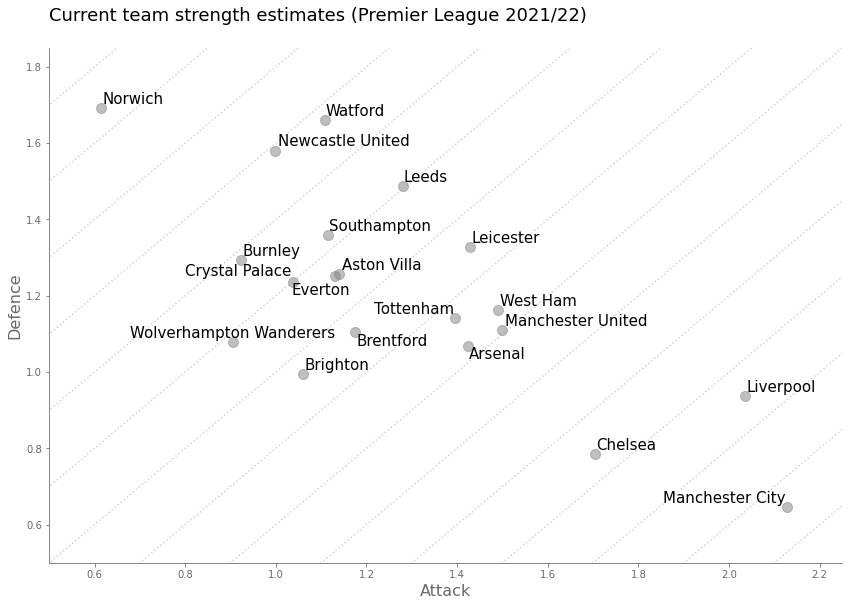

In [ ]:
from adjustText import adjust_text


x = params_team_df['Offence']
y = params_team_df['Defence']
z = params_team_df['team']

# Detailed scatter plot
fig, ax = plt.subplots(figsize=(12, 8))
fig.tight_layout(pad=2)
    
# plot the data
ax.scatter(x, y, alpha=0.5, color='gray', s = 100)

# Add text annotation to each point
texts = [plt.text(x[i], y[i], txt, size=15) for i, txt in enumerate(z)]
adjust_text(texts)

# Add diagonal gridlines
for gd in np.arange(-2, 2, 0.2):
    grid_x = np.linspace(0, 3) 
    grid_y = grid_x - gd
    ax.plot(grid_x, grid_y, zorder=-1, c='lightgray', linestyle='dotted')

# Add axis labels
ax.set_xlabel('Attack', fontsize=16, color='dimgray')
ax.set_ylabel('Defence', fontsize=16, color='dimgray')

# Change axes colour
ax.spines["bottom"].set_color('dimgray')
ax.spines["left"].set_color('dimgray')
ax.tick_params(colors='dimgray')
# Remove top and bottom spines
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
# Remove extra ticks
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()
# Set axes limits
ax.set_xlim([0.5, 2.25])
_ = ax.set_ylim([0.5, 1.85])

ax.set_title("Current team strength estimates (Premier League 2021/22)\n", loc='left', fontsize=18)

## Make predictions for the rest of the season

At varying NUFC team strengths

In [ ]:
played = [m for m in matches if m['is_result']]
unplayed = [m for m in matches if not m['is_result']]

In [ ]:
def copy_model(model):
    model_copy = wingback.team_strength.DCEnsemble()
    model_copy._model = wingback.team_strength.init_model(weight=lambda x: 1)
    model_copy._model.adapter = model._model.adapter
    model_copy._model.params = model._model.params.copy()
    return model_copy

In [ ]:
NUFC_TEAM_ID = 86


nufc_models = {}
for offence, defence in itertools.product(
    np.linspace(0.5, 2.0, 20), 
    np.linspace(0.5, 1.5, 20), 
):
    nufc_models[(offence, defence)] = copy_model(model)

    nufc_models[(offence, defence)]._model.params[mezzala.OffenceParameterKey(NUFC_TEAM_ID)] = np.log(offence)
    nufc_models[(offence, defence)]._model.params[mezzala.DefenceParameterKey(NUFC_TEAM_ID)] = np.log(defence)

In [ ]:
def make_predictions(model, unplayed):
    base_predictions = model.predict(unplayed)
    predictions = []
    for meta, preds in zip(unplayed, base_predictions):
        predictions.append(
            [{**meta, **p.__dict__} for p in preds]
        )
    return predictions


nufc_predictions = {
    k: make_predictions(m, unplayed)
    for k, m 
    in nufc_models.items()
}

In [ ]:
pd.DataFrame(make_predictions(model, [unplayed[-1]])[0])[
    ['home_team', 'away_team', 'home_goals', 'away_goals', 'probability']
]

,home_team,away_team,home_goals,away_goals,probability
0,Brentford,Leeds,0,0,5.869350e-02
1,Brentford,Leeds,0,1,6.758701e-02
2,Brentford,Leeds,0,2,3.951587e-02
3,Brentford,Leeds,0,3,1.532773e-02
4,Brentford,Leeds,0,4,4.459080e-03
...,...,...,...,...,...
671,Brentford,Leeds,25,21,7.334624e-40
672,Brentford,Leeds,25,22,3.879562e-41
673,Brentford,Leeds,25,23,1.962828e-42
674,Brentford,Leeds,25,24,9.516967e-44


## Get relegation probability (i.e. season forecast) at each team strength

In [ ]:


def group_by(xs, key):
    return itertools.groupby(sorted(xs, key=key), key=key)


@dataclasses.dataclass
class LeagueTableRow:
    team: typing.Any
    goals_for: int = 0
    goals_against: int = 0
    wins: int = 0
    draws: int = 0
    losses: int = 0

    def __add__(self, row):
        if self.team != row.team:
            raise ValueError('Only TableRows with the same team can be added')

        return LeagueTableRow(
            self.team,
            self.goals_for + row.goals_for,
            self.goals_against + row.goals_against,
            self.wins + row.wins,
            self.draws + row.draws,
            self.losses + row.losses
        )

    @property
    def points(self):
        return self.wins*3 + self.draws

    @property
    def goal_difference(self):
        return self.goals_for - self.goals_against

    @staticmethod
    def from_match(team, goals_for, goals_against):
        return LeagueTableRow(
            team=team,
            goals_for=goals_for,
            goals_against=goals_against,
            wins=1 if goals_for > goals_against else 0,
            draws=1 if goals_for == goals_against else 0,
            losses=1 if goals_for < goals_against else 0
        )


class BaseLeagueTable:
    def __init__(self, scorelines):
        self.scorelines = scorelines
        self.table = self.calculate_table(scorelines)

    @staticmethod
    def _repr_row(row):
        return '   '.join([
            str(row.team).ljust(25),
            str(row.wins).rjust(3),
            str(row.draws).rjust(3),
            str(row.losses).rjust(3),
            str(row.goals_for).rjust(3),
            str(row.goals_against).rjust(3),
            str(row.goal_difference).rjust(3),
            str(row.points).rjust(3)
        ])

    def __repr__(self):
        header = '   '.join([
            '# ',
            'Team'.ljust(25),
            'W'.rjust(3),
            'D'.rjust(3),
            'L'.rjust(3),
            'GF'.rjust(3),
            'GA'.rjust(3),
            'GD'.rjust(3),
            'Pt'.rjust(3)
        ])

        rows = [
            f'{str(position).ljust(2)} - {self._repr_row(row)}' for position, row in self.table.items()
        ]

        return '\n'.join(
            [header, ('='*max(len(r) for r in rows))] + rows
        )

    @staticmethod
    def home_team(scoreline):
        raise NotImplementedError

    @staticmethod
    def away_team(scoreline):
        raise NotImplementedError

    @staticmethod
    def home_goals(scoreline):
        raise NotImplementedError

    @staticmethod
    def away_goals(scoreline):
        raise NotImplementedError

    @staticmethod
    def compare_rows(a, b):
        raise NotImplementedError

    def evaluate_match(self, scoreline):
        home_result = LeagueTableRow.from_match(
            team=self.home_team(scoreline),
            goals_for=self.home_goals(scoreline),
            goals_against=self.away_goals(scoreline)
        )
        away_result = LeagueTableRow.from_match(
            team=self.away_team(scoreline),
            goals_for=self.away_goals(scoreline),
            goals_against=self.home_goals(scoreline)
        )
        return [home_result, away_result]

    def aggregate_results(self, scorelines):
        match_results = itertools.chain(*[self.evaluate_match(s) for s in scorelines])

        team_results = collections.defaultdict(lambda: LeagueTableRow(None))
        for team, results in group_by(match_results, key=lambda x: x.team):
            team_results[team] = functools.reduce(operator.add, results, LeagueTableRow(team))

        return team_results

    def calculate_table(self, scorelines):
        team_results = self.aggregate_results(scorelines)
        results_ordered = sorted(team_results.values(), key=functools.cmp_to_key(self.compare_rows), reverse=True)

        return {i + 1: r for i, r in enumerate(results_ordered)}


class HeadToHeadLeagueTable(BaseLeagueTable):
    def compare_rows(self, a, b):
        teams = [a.team, b.team]
        h2h_scorelines = [s for s in self.scorelines if (self.home_team(s) in teams) and (self.away_team(s) in teams)]
        h2h = self.aggregate_results(h2h_scorelines)

        def compare(f):
            if f(a) > f(b):
                return 1
            elif f(a) < f(b):
                return -1
            else:
                return None

        comparators = [
            lambda x: x.points,
            lambda x: h2h[x.team].points,
            lambda x: h2h[x.team].goal_difference,
            lambda x: h2h[x.team].goals_for,
            lambda x: x.goal_difference,
            lambda x: x.goals_for,
            # TODO: simulate playoff
        ]

        return functools.reduce(lambda x, y: x or compare(y), comparators, None) or (np.random.rand() > 0.5)


class EPLTable(HeadToHeadLeagueTable):
    @staticmethod
    def home_team(scoreline):
        return scoreline['home_team']

    @staticmethod
    def away_team(scoreline):
        return scoreline['away_team']

    @staticmethod
    def home_goals(scoreline):
        return scoreline['home_goals']

    @staticmethod
    def away_goals(scoreline):
        return scoreline['away_goals']


In [ ]:
current_table = EPLTable(played)

current_table

#    Team                          W     D     L    GF    GA    GD    Pt
1  - Manchester City              16     2     2    51    12    39    50
2  - Chelsea                      12     6     2    43    14    29    42
3  - Liverpool                    12     5     2    50    16    34    41
4  - Arsenal                      11     2     6    32    23     9    35
5  - Manchester United             9     4     5    30    26     4    31
6  - West Ham                      9     4     6    34    25     9    31
7  - Tottenham                     9     3     5    22    20     2    30
8  - Leicester                     7     4     7    31    33    -2    25
9  - Wolverhampton Wanderers       7     4     7    13    14    -1    25
10 - Brighton                      5     9     4    17    18    -1    24
11 - Crystal Palace                5     8     6    27    27     0    23
12 - Aston Villa                   7     1    10    24    28    -4    22
13 - Southampton                   4     9     6   

In [ ]:
def sample_match(scorelines):
    probs = [s['probability'] for s in scorelines]
    if np.isclose(sum(probs), 1):
        probs = np.asarray(probs) / np.sum(probs)

    return np.random.choice(scorelines, None, replace=False, p=probs)


def sample_matches(match_predictions):
    return [sample_match(m) for m in match_predictions]


def simulate_season(played, predictions):
    sim_matches = played + sample_matches(predictions)
    table = EPLTable(sim_matches)
    return table

def is_relegated(table):
    for ix in [18, 19, 20]:
        if table.table[ix].team == 'Newcastle United':
            return True
    return False


def estimate_relegation(played, predictions, n_sim):
    tables = [simulate_season(played, predictions) for _ in range(n_sim)]
    rel_pc = sum(is_relegated(t) for t in tables) / n_sim
    return rel_pc

Current relegation chance:

In [ ]:
estimate_relegation(played, make_predictions(model, unplayed), 1000)

0.833

Simulated chances:

In [ ]:
from pqdm.processes import pqdm


def estimate_relegation_pool(item):
    key, preds = item
    return (key, estimate_relegation(played, preds, 500))


nufc_relegation = dict(pqdm(
    nufc_predictions.items(),
    estimate_relegation_pool,
    n_jobs=8
))

SUBMITTING | :   0%|          | 0/400 [00:00<?, ?it/s]

PROCESSING | :   0%|          | 0/400 [00:01<?, ?it/s]

COLLECTING | :   0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
base_rate = np.exp(dict(model.to_dict()['params'])['Average rate'])

relegation_df = pd.DataFrame([
    {'offence': o*base_rate, 
     'defence': d*base_rate, 
     'probability': p}
    for (o, d), p 
    in nufc_relegation.items()
])

relegation_df

,offence,defence,probability
0,0.607166,0.607166,0.460
1,0.607166,0.671079,0.534
2,0.607166,0.734991,0.598
3,0.607166,0.798903,0.668
4,0.607166,0.862816,0.728
...,...,...,...
395,2.428666,1.565850,0.018
396,2.428666,1.629763,0.062
397,2.428666,1.693675,0.048
398,2.428666,1.757587,0.088


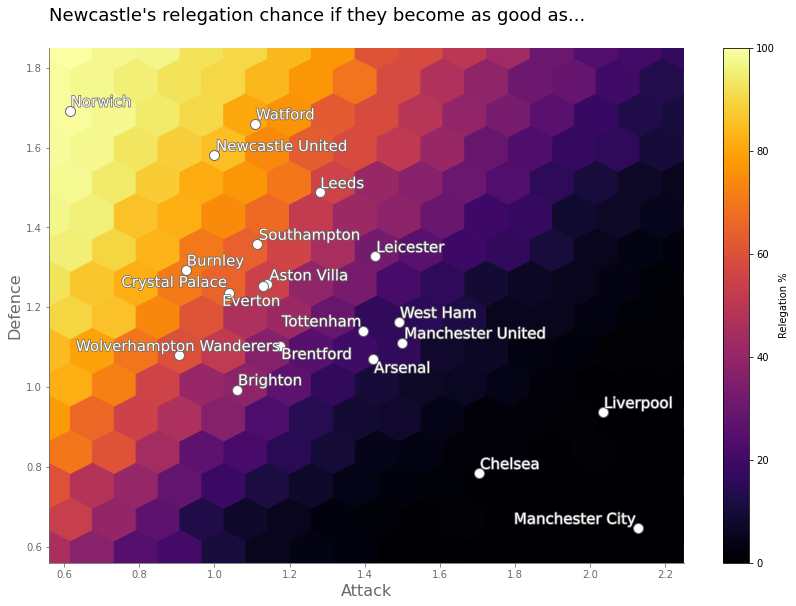

In [ ]:
import matplotlib.patheffects


fig, ax = plt.subplots(figsize=(12, 8))
fig.tight_layout(pad=2)

xlim = [0.50, 2.25]
ylim = [0.50, 1.85]


# Teams overlay:

x = params_team_df['Offence']
y = params_team_df['Defence']
z = params_team_df['team']
    
# plot the data
ax.scatter(x, y, color='white', edgecolor='dimgray', s=100)

# Add text annotation to each point
texts = []
for i, txt in enumerate(z):
    texts.append(plt.text(
        x[i],
        y[i],
        txt,
        size=15,
        color='white',
        path_effects=[matplotlib.patheffects.withStroke(linewidth=1.5, foreground='dimgray')]
    ))
adjust_text(texts)


# Relegation heatmap

x = relegation_df['offence']
y = relegation_df['defence']
z = relegation_df['probability']
plt.hexbin(x, y, C=z*100, gridsize=15, extent=xlim+ylim, zorder=-1, cmap='inferno')
cb = plt.colorbar()
cb.set_label('Relegation %')

ax.set_xlabel('Attack', fontsize=16, color='dimgray')
ax.set_ylabel('Defence', fontsize=16, color='dimgray')

# Styling
# Change axes colour
ax.spines["bottom"].set_color('dimgray')
ax.spines["left"].set_color('dimgray')
ax.tick_params(colors='dimgray')
# Remove top and bottom spines
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
# Remove extra ticks
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()
# Set axes limits
ax.set_xlim([xlim[0] + 0.06, xlim[1]])
ax.set_ylim([ylim[0] + 0.06, ylim[1]])

ax.set_title("Newcastle's relegation chance if they become as good as...\n", loc='left', fontsize=18)

plt.savefig('../relegation-heatmap.png', bbox_inches='tight')